## 175 - Adding Satellite Data

[Youtube](https://www.youtube.com/watch?v=Wb8RkFJqSpM)

In [1]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.plots as mpplots
from siphon.catalog import TDSCatalog
import numpy as np

from io import StringIO
from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays
from matplotlib.patheffects import withStroke
from metpy.cbook import get_test_data
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dt = datetime.utcnow() - timedelta(hours = 6)

### RTMA

In [3]:
rtma_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xtml')
rtma_data = rtma_cat.datasets['Full Collection (Reference / Forecast Time) Dataset'].remote_access(use_xarray = True)
rtma_data = rtma_data.metpy.parse_cf()
rtma_data

<xarray.Dataset>
Dimensions:                                                              (
                                                                          time2Offset: 1,
                                                                          : 2,
                                                                          reftime: 737,
                                                                          x: 2145,
                                                                          y: 1377,
                                                                          ...
                                                                          reftime1: 736,
                                                                          time4Offset: 1,
                                                                          height_above_ground1: 1,
                                                                          reftime3: 735,
                                                                          time1Offset: 1,
                                                                          altitude_above_msl: 1)
Coordinates: (12/20)
  * time2Offset                                                          (time2Offset) float64 ...
  * reftime                                                              (reftime) datetime64[ns] ...
    time2                                                                (reftime, time2Offset) datetime64[ns] ...
  * x                                                                    (x) float32 ...
  * y                                                                    (y) float32 ...
  * time3Offset                                                          (time3Offset) float64 ...
    ...                                                                   ...
    time4                                                                (reftime1, time4Offset) datetime64[ns] ...
  * height_above_ground1                                                 (height_above_ground1) float32 ...
  * reftime3                                                             (reftime3) datetime64[ns] ...
  * time1Offset                                                          (time1Offset) float64 ...
    time1                                                                (reftime3, time1Offset) datetime64[ns] ...
  * altitude_above_msl                                                   (altitude_above_msl) float32 ...
Dimensions without coordinates: 
Data variables: (12/23)
    LambertConformal_Projection                                          int32 ...
    time2Offset_bounds                                                   (time2Offset, ) float64 ...
    time2_bounds                                                         (reftime, time2Offset, ) datetime64[ns] ...
    Total_cloud_cover_Analysis_entire_atmosphere_single_layer            (reftime, time3Offset, y, x) float32 ...
    Pressure_error_surface                                               (reftime, time3Offset, y, x) float32 ...
    Wind_direction_from_which_blowing_error_height_above_ground          (reftime2, timeOffset, height_above_ground, y, x) float32 ...
    ...                                                                   ...
    Wind_speed_Analysis_height_above_ground                              (reftime, time3Offset, height_above_ground, y, x) float32 ...
    u-component_of_wind_Analysis_height_above_ground                     (reftime, time3Offset, height_above_ground, y, x) float32 ...
    v-component_of_wind_Analysis_height_above_ground                     (reftime, time3Offset, height_above_ground, y, x) float32 ...
    Geopotential_height_Analysis_surface                                 (reftime, time3Offset, y, x) float32 ...
    Dewpoint_temperature_Analysis_height_above_ground                    (reftime1, time4Offset, height_above_ground1, y, x) float32 ...
    Total_precipitation_Forecast_altitude_above_msl_1_Hour

In [4]:
pres = rtma_data['Pressure_Analysis_surface'].metpy.sel(reftime = dt, method = 'nearest').squeeze()
temp = rtma_data['Temperature_Analysis_height_above_ground'].metpy.sel(reftime3 = dt, method = 'nearest').squeeze()
dewp = rtma_data['Dewpoint_temperature_Analysis_height_above_ground'].metpy.sel(reftime1 = dt, method = 'nearest').squeeze()

In [5]:
temp

<xarray.DataArray 'Temperature_Analysis_height_above_ground' (y: 1377, x: 2145)>
[2953665 values with dtype=float32]
Coordinates:
  * x                     (x) float32 -2.763e+06 -2.761e+06 ... 2.682e+06
  * y                     (y) float32 -2.638e+05 -2.612e+05 ... 3.231e+06
    metpy_crs             object Projection: lambert_conformal_conic
    height_above_ground1  float32 2.0
    reftime3              datetime64[ns] 2024-01-03T12:00:00
    time1Offset           float64 0.0
    time1                 datetime64[ns] ...
Attributes: (12/13)
    long_name:                       Temperature Analysis @ Specified height ...
    units:                           K
    abbreviation:                    TMP
    grid_mapping:                    LambertConformal_Projection
    Grib_Variable_Id:                VAR_7-4--1-0_L103
    Grib2_Parameter:                 [0 0 0]
    ...                              ...
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:            Temperature
    Grib2_Level_Type:                103
    Grib2_Level_Desc:                Specified height level above ground
    Grib2_Generating_Process_Type:   Analysis
    Grib2_Statistical_Process_Type:  UnknownStatType--1

In [6]:
theta_e = mpcalc.equivalent_potential_temperature(pres, temp, dewp)
theta_e = mpcalc.smooth_gaussian(theta_e, n = 8)
plot_proj = theta_e.metpy.cartopy_crs

### METAR

In [7]:
airports_df = pd.read_csv(get_test_data('airport-codes.csv'))
airports_df.head()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code
0,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A
1,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK
2,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL
3,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,00AR,NaN,00AR
4,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,00AZ,NaN,00AZ


In [8]:
airports_df = airports_df[(airports_df['type'] == 'large_airport') | (airports_df['type'] == 'medium_airport')]
airports_df.head()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code
5464,4PS3,medium_airport,Paraport Airstrip,41.788417,-79.518586,1400.0,NaN,US,US-PA,Warren,4PS3,NaN,4PS3
6042,5A8,medium_airport,Aleknagik / New Airport,59.282600,-158.617996,66.0,NaN,US,US-AK,Aleknagik,5A8,WKK,5A8
10127,AGGH,medium_airport,Honiara International Airport,-9.428000,160.054993,28.0,OC,SB,SB-CT,Honiara,AGGH,HIR,NaN
10132,AGGM,medium_airport,Munda Airport,-8.327970,157.263001,10.0,OC,SB,SB-WE,NaN,AGGM,MUA,NaN
10153,AHJ,medium_airport,Hongyuan Airport,32.531540,102.352240,11600.0,AS,CN,CN-51,Aba,NaN,AHJ,NaN


In [9]:
metar_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

metar_file = metar_cat.datasets.filter_time_nearest(dt).remote_open()

metar_text = StringIO(metar_file.read().decode('ascii','ignore'))

sfc_data = parse_metar_file(metar_text, year = dt.year, month = dt.month)

sfc_units = sfc_data.units

sfc_units

{'station_id': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meters',
 'date_time': None,
 'wind_direction': 'degrees',
 'wind_speed': 'kts',
 'wind_gust': 'kts',
 'visibility': 'meters',
 'eastward_wind': 'kts',
 'northward_wind': 'kts',
 'current_wx1': None,
 'current_wx2': None,
 'current_wx3': None,
 'low_cloud_type': None,
 'low_cloud_level': 'feet',
 'medium_cloud_type': None,
 'medium_cloud_level': 'feet',
 'high_cloud_type': None,
 'high_cloud_level': 'feet',
 'highest_cloud_type': None,
 'highest_cloud_level:': None,
 'cloud_coverage': None,
 'air_temperature': 'degC',
 'dew_point_temperature': 'degC',
 'altimeter': 'inHg',
 'air_pressure_at_sea_level': 'hPa',
 'current_wx1_symbol': None,
 'current_wx2_symbol': None,
 'current_wx3_symbol': None}

In [10]:
sfc_data = sfc_data[sfc_data['station_id'].isin(airports_df['ident'])]

sfc_data = pandas_dataframe_to_unit_arrays(sfc_data, sfc_units)

sfc_data['u'], sfc_data['v'] = mpcalc.wind_components(sfc_data['wind_speed'], sfc_data['wind_direction'])

locs = plot_proj.transform_points(ccrs.PlateCarree(), sfc_data['longitude'].m, sfc_data['latitude'].m)

sfc_data_mask = mpcalc.reduce_point_density(locs[:, :2], 125000)

### Satellite Data

In [11]:
sat_catalog = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/current/catalog.xml')

list(sat_catalog.datasets)[-5:]

['OR_ABI-L2-CMIPC-M6C02_G16_s20240031711170_e20240031711170_c20240031711170.nc',
 'OR_ABI-L2-CMIPC-M6C02_G16_s20240031716170_e20240031716170_c20240031716170.nc',
 'OR_ABI-L2-CMIPC-M6C02_G16_s20240031721170_e20240031721170_c20240031721170.nc',
 'OR_ABI-L2-CMIPC-M6C02_G16_s20240031726170_e20240031726170_c20240031726170.nc',
 'OR_ABI-L2-CMIPC-M6C02_G16_s20240031731170_e20240031731170_c20240031731170.nc']

In [12]:
dt

datetime.datetime(2024, 1, 3, 11, 37, 44, 713189)

In [13]:
nearest_sat_time = dt.replace(minute = (dt.minute // 5 * 5) + 1)
nearest_sat_time

datetime.datetime(2024, 1, 3, 11, 36, 44, 713189)

In [14]:
time_str = nearest_sat_time.strftime('s%Y%j%H%M170')
time_str

's20240031136170'

In [15]:
for i, dataset in enumerate(sat_catalog.datasets):
	if time_str in dataset:
		sat_index = i
print(sat_index)

sat_data = sat_catalog.datasets[sat_index].remote_access(use_xarray = True)
cmi = sat_data.metpy.parse_cf('Sectorized_CMI')

216


### Plot

Text(0.5, 1.0, '2024-01-03 11Z')

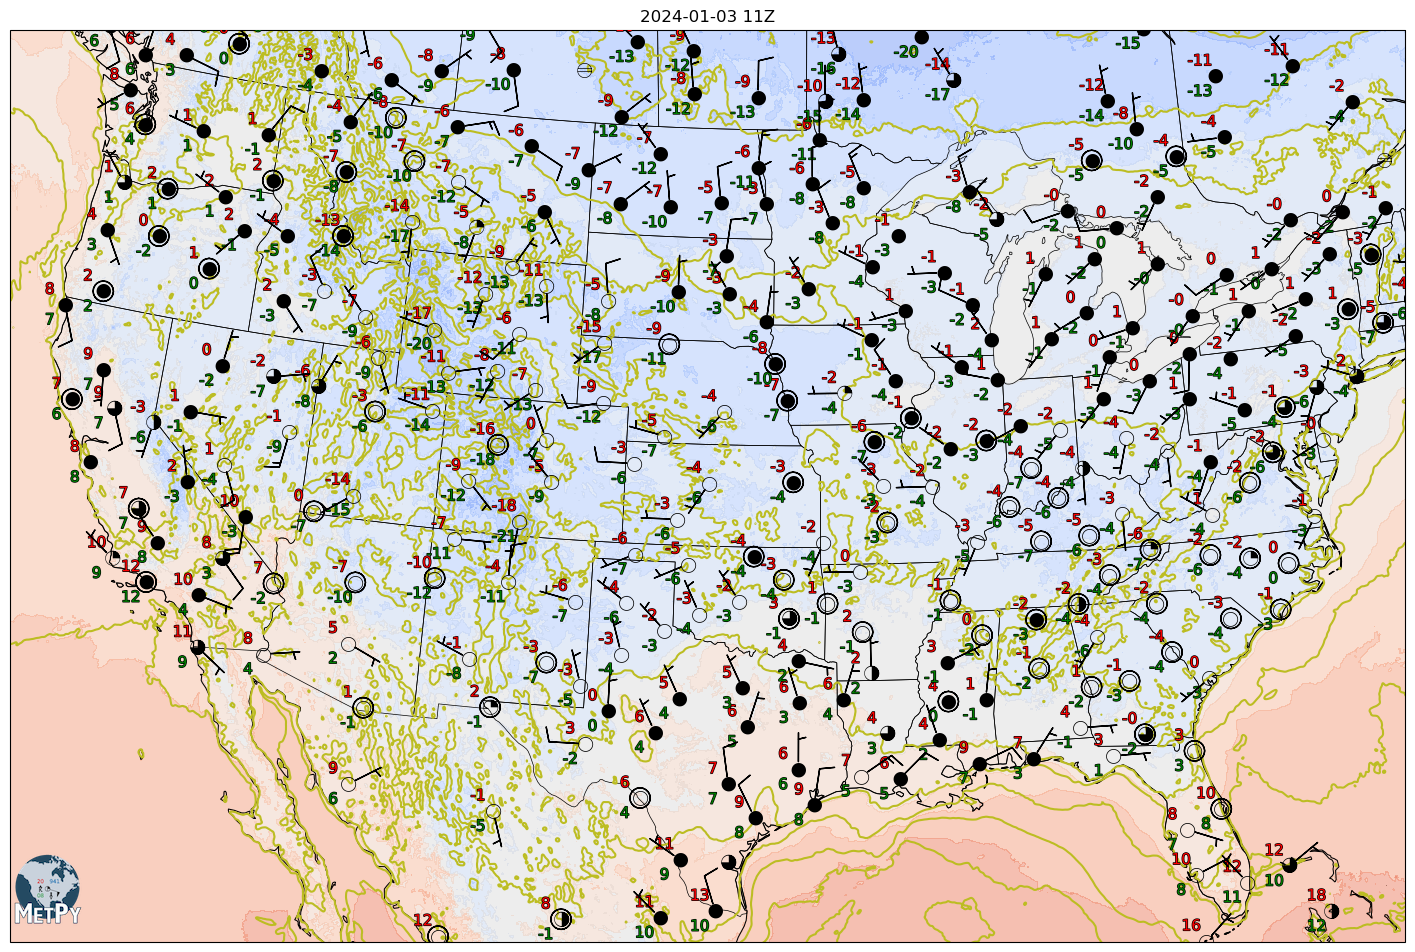

In [16]:
fig = plt.figure(figsize = (18, 14))
ax = fig.add_subplot(1, 1, 1, projection = plot_proj)
ax.set_extent((-122, -75, 25, 50), crs = ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth = 0.75)
ax.add_feature(cfeature.STATES, linewidth = 0.5)

# Satellite
image_extent = (cmi.metpy.x[0], cmi.metpy.x[-1], cmi.metpy.y[0], cmi.metpy.y[-1])
ax.imshow(cmi, extent = image_extent, origin = 'lower', cmap = 'Greys_r', regrid_shape = 6000, transform = cmi.metpy.cartopy_crs)

# Temperature
ax.contourf(temp.metpy.x, temp.metpy.y, temp - 273.15, transform = temp.metpy.cartopy_crs, levels = np.arange(-30, 40, 5), cmap = 'coolwarm', alpha = 0.5)

# Theta-E
ax.contour(theta_e.metpy.x, theta_e.metpy.y, theta_e, transform = theta_e.metpy.cartopy_crs, levels = np.arange(240, 400, 10), colors = 'tab:olive')

# Logo
mpplots.add_metpy_logo(fig)

# METARS
stn = mpplots.StationPlot(ax, sfc_data['longitude'][sfc_data_mask].m, sfc_data['latitude'][sfc_data_mask].m, transform = ccrs.PlateCarree(), fontsize = 11, zorder = 10, clip_on = True)
stn.plot_parameter('NW', sfc_data['air_temperature'][sfc_data_mask], color = 'red', path_effects = [withStroke(linewidth = 1, foreground = 'black')])
stn.plot_parameter('SW', sfc_data['dew_point_temperature'][sfc_data_mask], color = 'green', path_effects = [withStroke(linewidth = 1, foreground = 'black')])
stn.plot_symbol('C', sfc_data['cloud_coverage'][sfc_data_mask], mpplots.sky_cover)
stn.plot_barb(sfc_data['u'][sfc_data_mask], sfc_data['v'][sfc_data_mask])


plt.title(dt.strftime('%Y-%m-%d %HZ'))